In [1]:
# Here we import all the necessary libraries...
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
from torchvision.datasets import SVHN
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomAffine


In [3]:
# # # # # # # # # # # # # # # # # PART III # # # # # # # # # # # # # # # # #

# This will load the dataset from the same .ipynb directory... 
dataset = datasets.ImageFolder("./cnn_dataset")

# Dogs: - Mean values:  tensor([0.4978, 0.4590, 0.4005]) 
        # Standard deviation values:  tensor([0.2293, 0.2267, 0.2296])

# Cars: - Mean values:  tensor([0.5737, 0.4563, 0.3337])
        # Standard deviation values:  tensor([0.2227, 0.2294, 0.2266])

# Vehicles: - Mean values:  tensor([0.4426, 0.4351, 0.4180])
            # Standard deviation values:  tensor([0.2615, 0.2577, 0.2613])

# This will normalize the input dataset to have zero mean and unit variance...
normalized_Samples = transforms.Normalize(mean = [0.504, 0.450, 0.406], std = [0.237, 0.224, 0.239])
tensors_Samples = transforms.ToTensor()
transformed = transforms.Compose([tensors_Samples, normalized_Samples])

# Now we have pre-processed dataset ready to be splitted and training...
proccessed_Dataset = datasets.ImageFolder("./cnn_dataset", transform = transformed)

# This will split the dataset into training and validation sets...
train_80 = int((80/100) * (len(dataset)))
test_20 = int((20/100) * (len(dataset)))
train_Dataset, test_Dataset = torch.utils.data.random_split(proccessed_Dataset, [train_80 , test_20])

# This will create PyTorch DataLoader objects to be later loaded into NN architecture...
train_Dataloader = DataLoader(train_Dataset, batch_size = 64, shuffle = True)
test_Dataloader = DataLoader(test_Dataset, batch_size = 64, shuffle = False)

# This will print the insights of our dataset...
for i, j in test_Dataloader:
    print("Total number of images: ", len(dataset))
    print(f"Number of images in the batch (batch size): {i.shape[0]}")
    print(f"Number of channels in each image: {i.shape[1]}")
    print(f"Dimensions of each image: {i.shape[2], i.shape[3]}")
    
    break

Total number of images:  30000
Number of images in the batch (batch size): 128
Number of channels in each image: 3
Dimensions of each image: (64, 64)


In [7]:
# Neural Network training in progress...
# The actual neural network class is defined here...

class AlexArch(nn.Module):
    def __init__(self, num_classes = 3):
        super(AlexArch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(64, 192, kernel_size = 3, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x_Fea = self.features(x)
        x_Avg = self.avgpool(x_Fea)
        x_Flat = torch.flatten(x_Avg, 1)
        x_For = self.classifier(x_Flat)
        
        return x_For

# This will check if GPU harnessing is available otherwise it will assign cpu as training resource...
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

# This function will perform actual training...
def train(dataloader, al_Mo, loss_Func, optimizer):
    
    size = len(dataloader.dataset)
    al_Mo.train()
    train_Loss = 0
    train_Correct = 0
    train_Total = 0
    for batch, (i, j) in enumerate(dataloader):
        pr, ls = i.to(device), j.to(device)

        # This will compute prediction error...
        pred = al_Mo(pr)
        loss = loss_Func(pred, ls)

        # This will perform the backpropagation to optimize the network with optimal weights...
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_Loss += loss.item()
        train_Total += ls.size(0)
        train_Correct += (torch.argmax(pred, dim = 1) == j.to(device)).sum().item()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(pr)
            print(f"Training Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_Loss /= size
    train_Accuracy = 100 * train_Correct / train_Total
    print(f"Train Accuracy: {(train_Accuracy):>0.1f}%, Avg Training Loss: {loss:>8f} \n")

    return train_Loss, train_Accuracy

# This function is perform the testing by the trained model over new data...
def test(dataloader, al_Mo, loss_Func):
    
    size = len(dataloader.dataset)
    al_Mo.eval()
    test_Loss = 0
    predictions = 0
    with torch.no_grad():
        for i, j in dataloader:
            k, l = i.to(device), j.to(device)
            pred = al_Mo(k.float())
            test_Loss += loss_Func(pred.squeeze(), l.long()).item()
            predictions += (torch.argmax(pred, dim = 1) == l.to(device)).type(torch.float).sum().item()
    test_Loss /= size 
    test_Accuracy = 100 * (predictions / size)
    print(f"Test Accuracy: {(test_Accuracy):>0.1f}%, Avg Testing Loss: {test_Loss:>8f} \n")
    
    return test_Loss, test_Accuracy

# This will movel model to selected device...
alex_Model = AlexArch().to(device)

epochs = 15
learning_Rate = 1e-4
loss_Func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alex_Model.parameters(), lr = learning_Rate)
total_Train_Loss = []
total_Test_Loss = []
total_Test_Accuracies = []
total_Train_Accuracies = []
best_test_loss = float("inf")
this_is_too_much = 3
too_much = 0

# The actual training, testing is executed from here, it will run the loop till assigned epochs...
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_L, tr_A = train(train_Dataloader, alex_Model, loss_Func, optimizer)
    te_L, te_A = test(test_Dataloader, alex_Model, loss_Func)
    total_Train_Loss.append(tr_L)
    total_Train_Accuracies.append(tr_A)
    total_Test_Loss.append(te_L)
    total_Test_Accuracies.append(te_A)

    if te_L < best_test_loss:
        best_test_loss = te_L
        too_much = 0
    else:
        too_much += 1

    if too_much >= this_is_too_much:
        print("Early stopping for your own good...")
        break

    print()

# This will save the trained model to be used later for predicting new images...
torch.save(alex_Model.state_dict(), "best_Alex.pt")

Using cuda device
Epoch 1
-------------------------------
Training Loss: 1.100038  [    0/24000]
Training Loss: 0.589894  [ 6400/24000]
Training Loss: 0.407103  [12800/24000]
Training Loss: 0.431248  [19200/24000]
Train Accuracy: 74.7%, Avg Training Loss: 0.348853 

Test Accuracy: 85.5%, Avg Testing Loss: 0.002878 


Epoch 2
-------------------------------
Training Loss: 0.335399  [    0/24000]
Training Loss: 0.466633  [ 6400/24000]
Training Loss: 0.273391  [12800/24000]
Training Loss: 0.321780  [19200/24000]
Train Accuracy: 86.1%, Avg Training Loss: 0.398643 

Test Accuracy: 88.1%, Avg Testing Loss: 0.002452 


Epoch 3
-------------------------------
Training Loss: 0.228332  [    0/24000]
Training Loss: 0.261809  [ 6400/24000]
Training Loss: 0.352726  [12800/24000]
Training Loss: 0.162314  [19200/24000]
Train Accuracy: 88.7%, Avg Training Loss: 0.294915 

Test Accuracy: 89.4%, Avg Testing Loss: 0.002267 


Epoch 4
-------------------------------
Training Loss: 0.312711  [    0/24000]


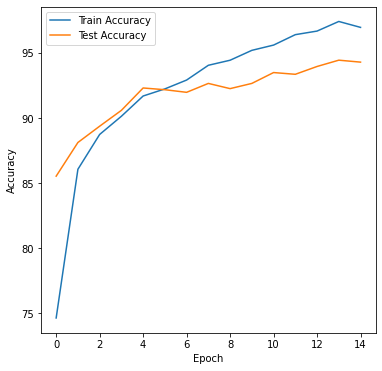

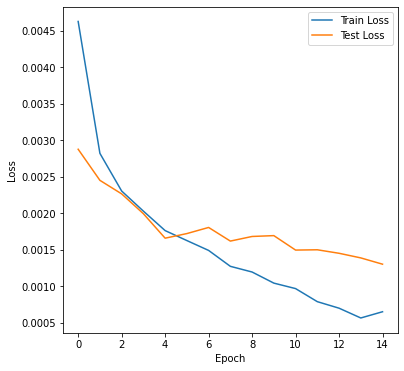

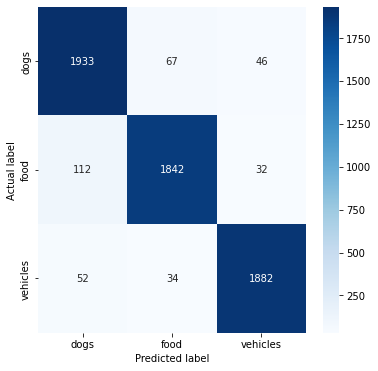

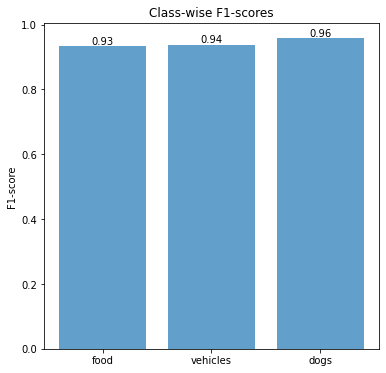

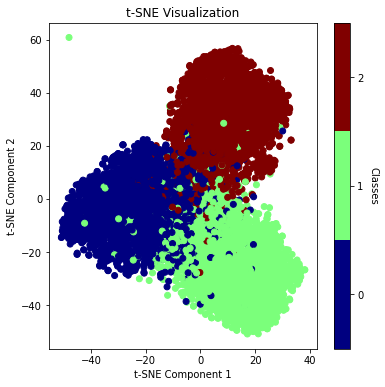

In [9]:
# # # # # # # # # # # # # # # # # VISUALIZATION GRAPHS OF PART III # # # # # # # # # # # # # # # # #

# This will plot the Training vs Testing accuracy graph...
fig = plt.figure(figsize = (6, 6))
plt.plot(total_Train_Accuracies, label = "Train Accuracy")
plt.plot(total_Test_Accuracies, label = "Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# This will plot the Training vs Testing loss graph...
fig = plt.figure(figsize = (6, 6))
plt.plot(total_Train_Loss, label = "Train Loss")
plt.plot(total_Test_Loss, label = "Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

true_Labels = []
features = []
predicted_Labels = []

# This will predict from the saved model to be visualized for confusion matrix...
with torch.no_grad():
    for i, j in test_Dataloader:
        k, l = i.to(device), j.to(device)
        pred = alex_Model(k.float())
        features_Pred = alex_Model.features(k.float())
        features.extend(features_Pred.cpu().numpy())
        true_Labels.extend(l.cpu().numpy())
        predicted_Labels.extend(torch.argmax(pred, dim = 1).cpu().numpy())

# This will plot the confusion matrix graph...
fig = plt.figure(figsize=(6, 6))
con_Mat = confusion_matrix(true_Labels, predicted_Labels)
sns.heatmap(con_Mat, annot = True, cmap = "Blues", fmt = "g", 
            xticklabels = ["dogs", "food", "vehicles"], 
                yticklabels = ["dogs", "food", "vehicles"])
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

# This will plot the F1-Score bars for each class...
fig = plt.figure(figsize=(6, 6))
f1_Class = f1_score(true_Labels, predicted_Labels, average=None)
classes = ["food", "vehicles", "dogs"]
length = np.arange(len(classes))
bars = plt.bar(length, f1_Class, align = "center", alpha = 0.7)
plt.xticks(length, classes)
plt.ylabel("F1-score")
plt.title("Class-wise F1-scores")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
            f"{height:.2f}", ha = "center", va = "bottom")
plt.show()

# This will plot the t-SNE graph...
fig = plt.figure(figsize=(6, 6))
flatten_Features = np.array(features).reshape(len(features), -1)
tsne = TSNE(n_components = 2, random_state = 0)
tsne_features = tsne.fit_transform(flatten_Features)
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c = true_Labels, cmap = plt.get_cmap("jet", 3))
class_Labels = ["dogs", "food", "vehicles"]
tick_locs = np.arange(0, 3, 1)
cbar = plt.colorbar(ticks = tick_locs)
cbar.ax.set_yticklabels(class_Labels)
cbar.ax.set_ylabel("Classes", rotation = 270, labelpad = 15)
plt.clim(-0.5, 2.5)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization")
plt.show()

In [2]:
# # # # # # # # # # # # # # # # #  PART IV # # # # # # # # # # # # # # # # #


# This will define the normalization and data augmentation transforms...
normalized_SVHN = transforms.Normalize(mean = [0.504, 0.450, 0.406], std = [0.237, 0.224, 0.239])
tensors_SVHN = transforms.ToTensor()

augmentation_Train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate = (0.1, 0.1)),
    transforms.RandomVerticalFlip(),
    tensors_SVHN,
    normalized_SVHN
])

augmentation_Test = transforms.Compose([tensors_SVHN, normalized_SVHN])

augmented_SVHNtrain = SVHN(root = "./svhn_data", split = "train", transform = augmentation_Train, download = True)
augmented_SVHNtest = SVHN(root = "./svhn_data", split = "test", transform = augmentation_Test, download = True)

# This will create PyTorch DataLoader objects...
train_SVHN = DataLoader(augmented_SVHNtrain, batch_size = 128, shuffle = True)
test_SVHN = DataLoader(augmented_SVHNtest, batch_size = 128, shuffle = False)

for i, j in test_SVHN:
    print("Total number of images to be trained: ", len(augmented_SVHNtrain))
    print("Total number of images to be tested: ", len(augmented_SVHNtest))
    print(f"Number of images in the batch (batch size): {i.shape[0]}")
    print(f"Number of channels in each image: {i.shape[1]}")
    print(f"Dimensions of each image: {i.shape[2], i.shape[3]}")
    
    break

Using downloaded and verified file: ./svhn_data/train_32x32.mat
Using downloaded and verified file: ./svhn_data/test_32x32.mat
Total number of images to be trained:  73257
Total number of images to be tested:  26032
Number of images in the batch (batch size): 128
Number of channels in each image: 3
Dimensions of each image: (32, 32)


In [5]:
# Neural Network training in progress...
# The actual neural network class is defined here...

class SVHNArch(nn.Module):
    def __init__(self, num_classes = 10):
        super(SVHNArch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, kernel_size = 3, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x_Fea = self.features(x)
        x_Avg = self.avgpool(x_Fea)
        x_Flat = torch.flatten(x_Avg, 1)
        x_For = self.classifier(x_Flat)
        
        return x_For

# This will check if GPU harnessing is available otherwise it will assign cpu as training resource...
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

# This function will perform actual training...
def train(dataloader, svhn_Mo, loss_Func, optimizer):
    
    size = len(dataloader.dataset)
    svhn_Mo.train()
    train_Loss = 0
    train_Correct = 0
    train_Total = 0
    for batch, (i, j) in enumerate(dataloader):
        pr, ls = i.to(device), j.to(device)

        # This will compute prediction error...
        pred = svhn_Mo(pr)
        loss = loss_Func(pred, ls)

        # This will perform the backpropagation to optimize the network with optimal weights...
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_Loss += loss.item()
        train_Total += ls.size(0)
        train_Correct += (torch.argmax(pred, dim = 1) == j.to(device)).sum().item()

        if batch % 200 == 0:
            loss, current = loss.item(), batch * len(pr)
            print(f"Training Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_Loss /= size
    train_Accuracy = 100 * train_Correct / train_Total
    print(f"Train Accuracy: {(train_Accuracy):>0.1f}%, Avg Training Loss: {loss:>8f} \n")

    return train_Loss, train_Accuracy

# This function is perform the testing by the trained model over new data...
def test(dataloader, svhn_Mo, loss_Func):

    size = len(dataloader.dataset)
    svhn_Mo.eval()
    test_Loss = 0
    predictions = 0
    with torch.no_grad():
        for i, j in dataloader:
            k, l = i.to(device), j.to(device)
            pred = svhn_Mo(k.float())
            test_Loss += loss_Func(pred.squeeze(), l.long()).item()
            predictions += (torch.argmax(pred, dim = 1) == l.to(device)).type(torch.float).sum().item()
    test_Loss /= size 
    test_Accuracy = 100 * (predictions / size)
    print(f"Test Accuracy: {(test_Accuracy):>0.1f}%, Avg Testing Loss: {test_Loss:>8f} \n")
    
    return test_Loss, test_Accuracy

# This will movel model to selected device...
SVHN_Model = SVHNArch().to(device)

epochs = 75
learning_Rate = 1e-4
loss_Func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SVHN_Model.parameters(), lr = learning_Rate)
total_Train_Loss_SVHN = []
total_Test_Loss_SVHN = []
total_Test_Accuracies_SVHN = []
total_Train_Accuracies_SVHN = []

# The actual training, testing is executed from here, it will run the loop till assigned epochs...
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_L, tr_A = train(train_SVHN, SVHN_Model, loss_Func, optimizer)
    te_L, te_A = test(test_SVHN, SVHN_Model, loss_Func)
    total_Train_Loss_SVHN.append(tr_L)
    total_Train_Accuracies_SVHN.append(tr_A)
    total_Test_Loss_SVHN.append(te_L)
    total_Test_Accuracies_SVHN.append(te_A)

    print()

# This will save the trained model to be used later for predicting new images...
torch.save(SVHN_Model.state_dict(), "best_SVHN.pt")


Using cuda device
Epoch 1
-------------------------------
Training Loss: 2.301041  [    0/73257]
Training Loss: 2.241075  [25600/73257]
Training Loss: 2.219712  [51200/73257]
Train Accuracy: 19.1%, Avg Training Loss: 2.134364 

Test Accuracy: 25.6%, Avg Testing Loss: 0.016738 


Epoch 2
-------------------------------
Training Loss: 2.187873  [    0/73257]
Training Loss: 1.992412  [25600/73257]
Training Loss: 1.823568  [51200/73257]
Train Accuracy: 31.6%, Avg Training Loss: 1.802842 

Test Accuracy: 41.6%, Avg Testing Loss: 0.012533 


Epoch 3
-------------------------------
Training Loss: 1.686499  [    0/73257]
Training Loss: 1.435627  [25600/73257]
Training Loss: 1.331342  [51200/73257]
Train Accuracy: 43.4%, Avg Training Loss: 1.300294 

Test Accuracy: 55.0%, Avg Testing Loss: 0.009742 


Epoch 4
-------------------------------
Training Loss: 1.405334  [    0/73257]
Training Loss: 1.206203  [25600/73257]
Training Loss: 1.157769  [51200/73257]
Train Accuracy: 54.5%, Avg Training Los

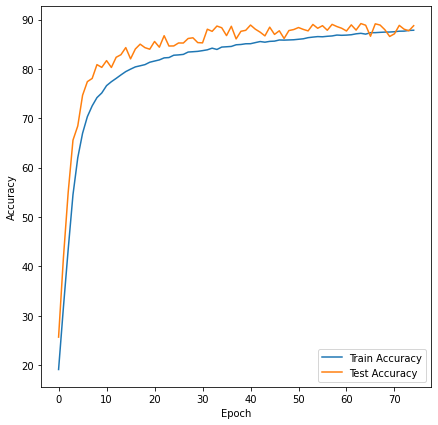

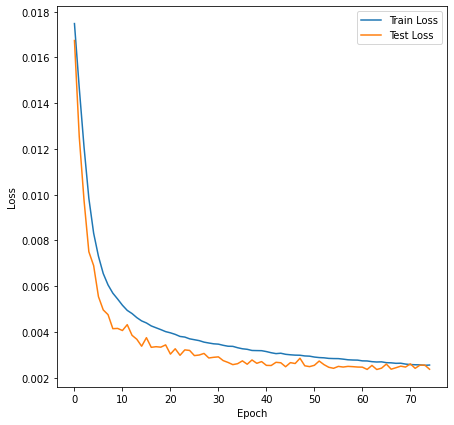

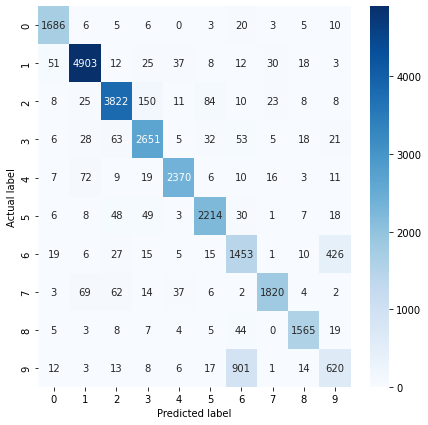

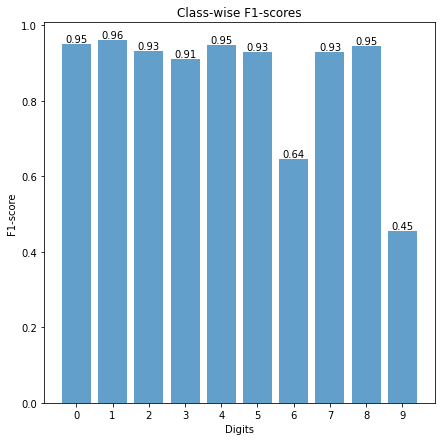

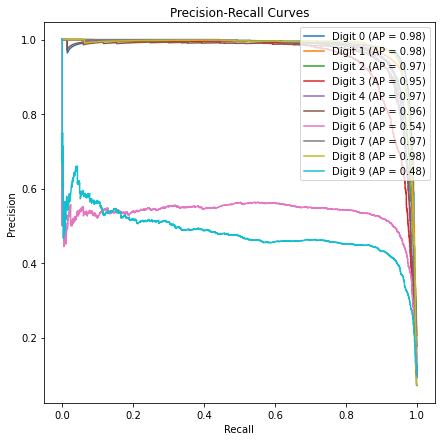

In [7]:
# # # # # # # # # # # # # # # # # VISUALIZATION GRAPHS OF PART IV # # # # # # # # # # # # # # # # #

# This will plot the Training vs Testing accuracy graph...
fig = plt.figure(figsize = (7, 7))
plt.plot(total_Train_Accuracies_SVHN, label = "Train Accuracy")
plt.plot(total_Test_Accuracies_SVHN, label = "Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# This will plot the Training vs Testing loss graph...
fig = plt.figure(figsize = (7, 7))
plt.plot(total_Train_Loss_SVHN, label = "Train Loss")
plt.plot(total_Test_Loss_SVHN, label = "Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

true_Labels_SVHN = []
features_SVHN = []
predicted_Labels_SVHN = []

# This will predict from the saved model to be visualized for confusion matrix...
with torch.no_grad():
    for i, j in test_SVHN:
        k, l = i.to(device), j.to(device)
        pred = SVHN_Model(k.float())
        features_Pred = SVHN_Model.features(k.float())
        features_SVHN.extend(features_Pred.cpu().numpy())
        true_Labels_SVHN.extend(l.cpu().numpy())
        predicted_Labels_SVHN.extend(torch.argmax(pred, dim = 1).cpu().numpy())

# This will plot the confusion matrix graph...
fig = plt.figure(figsize = (7, 7))
con_Mat = confusion_matrix(true_Labels_SVHN, predicted_Labels_SVHN)
sns.heatmap(con_Mat, annot = True, cmap = "Blues", fmt = "g", 
            xticklabels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
                yticklabels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

# This will plot the F1-Score bars for each class...
fig = plt.figure(figsize = (7, 7))
f1_Class = f1_score(true_Labels_SVHN, predicted_Labels_SVHN, average = None)
classes = np.arange(0, 10)
length = np.arange(len(classes))
bars = plt.bar(length, f1_Class, align = "center", alpha = 0.7)
plt.xticks(length, classes)
plt.xlabel("Digits")
plt.ylabel("F1-score")
plt.title("Class-wise F1-scores")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
            f"{height:.2f}", ha = "center", va = "bottom")
plt.show()

# This function will compute the precision recall to be later visualized as graph...
def com_Pre_Re(test_Loader, model):
    truth = []
    score = []
    
    # This will get the true labels and predicted scores...
    with torch.no_grad():
        for i, j in test_Loader:
            k, l = i.to(device), j.to(device)
            pred = model(k.float())
            truth.extend(l.tolist())
            score.extend(pred.tolist())
    
    # This will binarize the true labels and reshape the predicted scores...
    truth = label_binarize(truth, classes = range(10))
    score = np.array(score)
    
    n_Classes = truth.shape[1]
    average_Precision = {}
    precision = {}
    recall = {}
    
    # This will actual compute the Precision-Recall curve and average precision for each class...
    for i in range(n_Classes):
        precision[i], recall[i], _ = precision_recall_curve(truth[:, i], score[:, i])
        average_Precision[i] = average_precision_score(truth[:, i], score[:, i])

    return precision, recall, average_Precision

precision, recall, avg_Pre = com_Pre_Re(test_SVHN, SVHN_Model)

# This will plot the Precision-Recall curve for each class...
fig = plt.figure(figsize = (7, 7))
for i in range(10):
    plt.plot(recall[i], precision[i], label = f"Digit {i} (AP = {avg_Pre[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc = "upper right")
plt.show()


In [ ]:
# # # # # # # # # # # # # # # # # # # # REFERENCES # # # # # # # # # # # # # # # # # # # # #

# https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html

# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

# https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data

# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

# https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html

# https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

# https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

# https://huggingface.co/spaces/samuelinferences/transformers-can-do-bayesian-inference/blob/01c121379dfb1bc8ade07455f7f49810c720709c/prior-fitting/tabular.py
